# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best? The simple linear model I ended up with has RMSE of 73438 and R2 of 0.894. This high R2 value suggests that this model accounts for almost all of the variation in the price of cars.
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? Based on the partial regression plots, there are not any significant non linear relationships between the numeric variables in the model.
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection? I saw a bit of potential overfitting in my complex model, as the R^2 on the training set is significantly higher than the R^2 on the test set. The mean absolute error on the test set is double the mean absolute error on the training set, further suggesting overfitting.
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         976 non-null    int64 
 1   Make               976 non-null    object
 2   Make_Year          976 non-null    int64 
 3   Color              976 non-null    object
 4   Body_Type          976 non-null    object
 5   Mileage_Run        976 non-null    int64 
 6   No_of_Owners       976 non-null    object
 7   Seating_Capacity   976 non-null    int64 
 8   Fuel_Type          976 non-null    object
 9   Transmission       976 non-null    object
 10  Transmission_Type  976 non-null    object
 11  Price              976 non-null    int64 
dtypes: int64(5), object(7)
memory usage: 91.6+ KB


73438.16326530612

0.8942770642897299

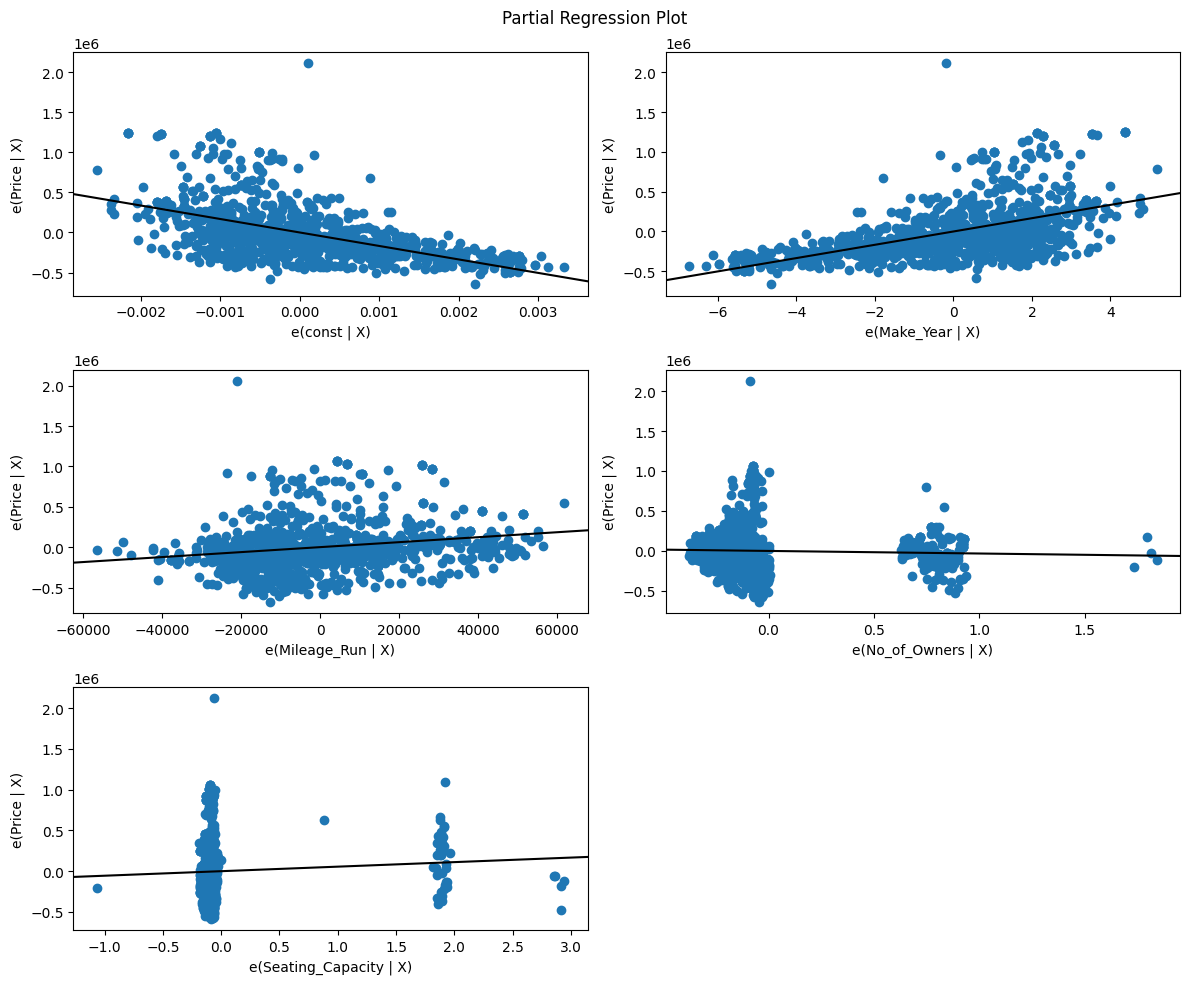

np.float64(69990.58617973574)

np.float64(120267.38143875408)

0.9649042756514831

0.8738900372351861

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score

import pandas as pd

# Load the dataset
df = pd.read_csv('cars_hw.csv')

# Display basic information and the first few rows
df.info(), df.head()


# Drop the unnamed index column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Convert 'No_of_Owners' to numerical by extracting the first character (e.g., "1st" -> 1)
df['No_of_Owners'] = df['No_of_Owners'].str.extract('(\d)').astype(int)

# Define features and target
X = df.drop(columns=['Price'])
y = df['Price']

# Identify categorical and numerical columns
categorical_features = ['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type']
numerical_features = ['Make_Year', 'Mileage_Run', 'No_of_Owners', 'Seating_Capacity']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define the model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.model_selection import train_test_split


# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

display(mae,r2)

import numpy as np

# Feature importance
feature_names = numerical_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
feature_importances = model.named_steps['regressor'].feature_importances_

# Model parameter statistics
param_stats = {
    "Mean Feature Importance": np.mean(feature_importances),
    "Std Feature Importance": np.std(feature_importances),
    "Min Feature Importance": np.min(feature_importances),
    "Max Feature Importance": np.max(feature_importances),
    "Top 5 Important Features": [feature_names[i] for i in np.argsort(feature_importances)[-5:][::-1]]
}

param_stats

# Reload necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_partregress_grid




# Prepare the data for statsmodels
X_numeric = sm.add_constant(df[numerical_features])  # Add intercept
y = df['Price']

# Fit an OLS model
ols_model = sm.OLS(y, X_numeric).fit()

# Generate partial regression plots
fig = plt.figure(figsize=(12, 10))
plot_partregress_grid(ols_model, fig=fig)
plt.tight_layout()
plt.show()

from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

# Define transformations
log_transformer = FunctionTransformer(np.log1p, validate=True)  # log(1 + x) to handle zeros

# Identify numerical and categorical features
categorical_features = ['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type']
numerical_features = ['Make_Year', 'Mileage_Run', 'No_of_Owners', 'Seating_Capacity']

# Preprocessing pipeline with transformations
complex_preprocessor = ColumnTransformer([
    ('num', make_pipeline(log_transformer, PolynomialFeatures(degree=2, include_bias=False)), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Define a more complex model (Random Forest with engineered features)
complex_model = Pipeline([
    ('preprocessor', complex_preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42, max_depth=10))
])

# Train the complex model
complex_model.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = complex_model.predict(X_train)
y_test_pred = complex_model.predict(X_test)

# Compute RMSE and R² for train and test sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)


display(rmse_train, rmse_test, r2_train, r2_test)


